In [1]:
import torch
import sys
sys.path.append('..')
from model.utils import LMHyperParams, SmModel, ModelChoice
from dataset.squad import UltraFeedbackDataModule
from transformers import AutoTokenizer, PreTrainedTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft.tuners.lora.config import LoraConfig
from transformers import TrainingArguments
from trl import DPOTrainer, DPOConfig
from typing import cast
from peft.peft_model import PeftModel
import gc
%load_ext autoreload
%autoreload 2

/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "HuggingFaceTB/SmolLM2-135M-Instruct"  # replace with your model id

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
)
tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained(model_id)  # type: ignore
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # to prevent errors with FA
tokenizer.truncation_side = "left"  # to prevent cutting off last generation

In [3]:
data_module = UltraFeedbackDataModule(2, tokenizer, 1024, 100, False)
# debugger will fail without this
data_module.num_workers = 1
data_module.setup("fit")

2024-11-24 02:42:46.872 | INFO     | dataset.squad:setup:220 - Loading dataset for stage fit


2024-11-24 02:42:48.738 | INFO     | dataset.squad:setup:231 - Processing dataset for stage fit, workers: 1, cache dir dataset_caches/ultrafeedback
Map: 100%|██████████| 10/10 [00:00<00:00, 925.79 examples/s]


In [27]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
data_module.train_dataset

Dataset({
    features: ['source', 'prompt', 'chosen', 'chosen-rating', 'chosen-model', 'rejected', 'rejected-rating', 'rejected-model'],
    num_rows: 90
})

In [ ]:
# max_prompt_length is the maximum length of the prompt and the max_length is the maximum length of the prompt + chosen or rejected response
prompt_length = 1024
max_seq_length = 1512

peft_config = LoraConfig(
    lora_alpha=128,
    lora_dropout=0.05,
    r=256,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
)

args = DPOConfig(
    output_dir="doplhin-dpo",
    num_train_epochs=1,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    learning_rate=5e-5,
    max_grad_norm=0.3,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_steps=25,
    save_steps=500,
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=700,
    bf16=True,
    tf32=True,
    push_to_hub=False,
    report_to="tensorboard",
    # debugger will fail without this
    dataloader_num_workers=0,
    dataset_num_proc=1,
    max_length=max_seq_length,
    max_prompt_length=prompt_length,
    precompute_ref_log_probs=True,
    dataloader_pin_memory=True,
    beta=0.1,
    loss_type="sigmoid",
)


trainer = DPOTrainer(
    model,
    ref_model=None,  # set to none since we use peft
    peft_config=peft_config,
    args=args,
    train_dataset=data_module.train_dataset,
    eval_dataset=data_module.val_dataset,
    tokenizer=tokenizer,  # type: ignore
)

/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Tokenizing eval dataset: 100%|██████████| 10/10 [00:00<00:00, 388.85 examples/s]


In [16]:
for i, batch in enumerate(trainer.get_train_dataloader()):
    print(i)

0
1
2
3
4
5
6
7


/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_input_ids = [torch.tensor(example["prompt_input_ids"]) for example in examples]
/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chosen_input_ids = [torch.tensor(example["chosen_input_ids"]) for example in examples]
/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

In [34]:
from tqdm import tqdm
from trl.trainer.dpo_trainer import PreferenceCollator
outputs = []
# call this to precompute logprobs
trainer.get_train_dataloader()
collator = PreferenceCollator(tokenizer.pad_token_id, "pt")
with torch.no_grad():
    for sample in tqdm(trainer.train_dataset):
        sample_collated = collator([sample])
        loss, metrics = trainer.compute_loss(model, sample_collated, True)
        outputs.append(
            {"loss": loss.item(), "metrics": metrics, "prompt": sample["prompt"], "chosen": sample["chosen"], "rejected": sample["rejected"]}
        )

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: rejected, rejected-rating, ref_chosen_logps, rejected-model, source, prompt, ref_rejected_logps, chosen, chosen-model, chosen-rating. If rejected, rejected-rating, ref_chosen_logps, rejected-model, source, prompt, ref_rejected_logps, chosen, chosen-model, chosen-rating are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
  0%|          | 0/90 [00:00<?, ?it/s]

/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_input_ids = [torch.tensor(example["prompt_input_ids"]) for example in examples]
/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chosen_input_ids = [torch.tensor(example["chosen_input_ids"]) for example in examples]
/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

In [35]:
outputs[0]['metrics']

{'rewards/chosen': tensor(0.2612),
 'rewards/rejected': tensor(-0.0292),
 'rewards/accuracies': tensor(1.),
 'rewards/margins': tensor(0.2904),
 'logps/chosen': tensor(-259.7500, dtype=torch.float16),
 'logps/rejected': tensor(-158.7500, dtype=torch.float16),
 'logits/chosen': tensor(2.6895, dtype=torch.float16),
 'logits/rejected': tensor(4.6875, dtype=torch.float16)}

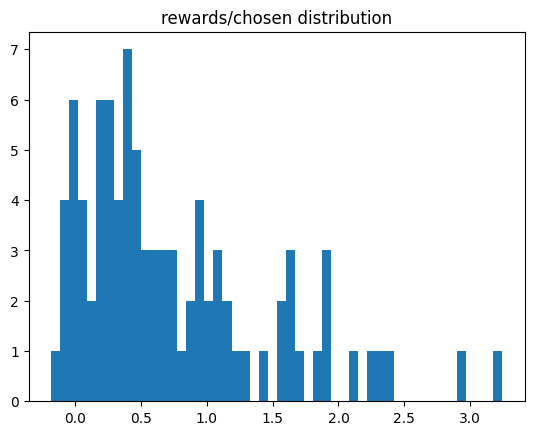

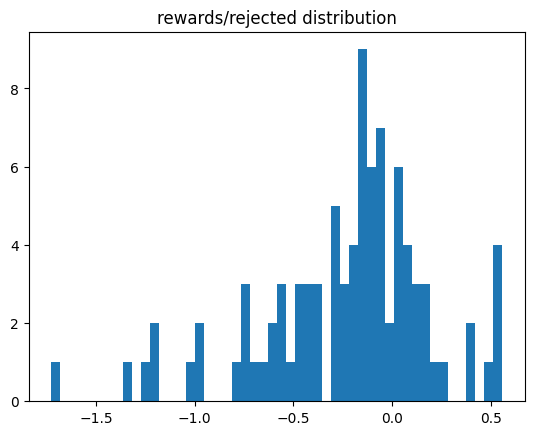

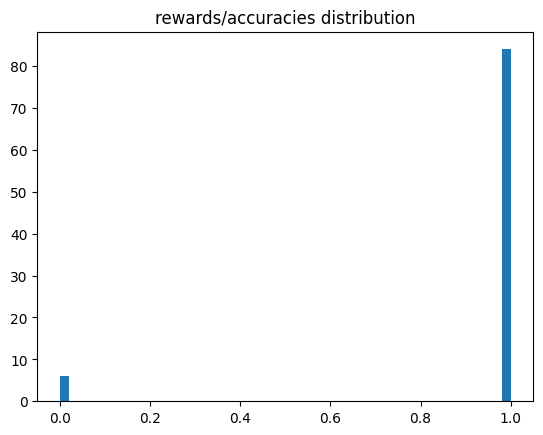

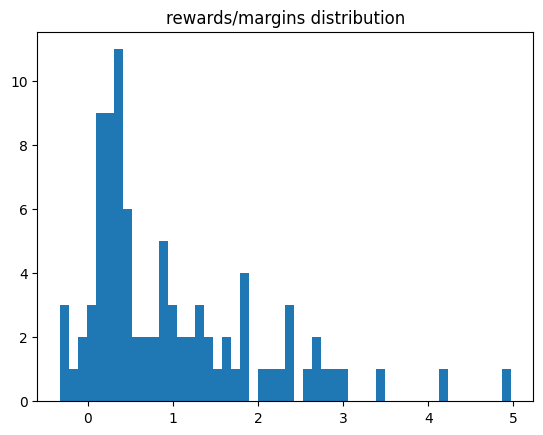

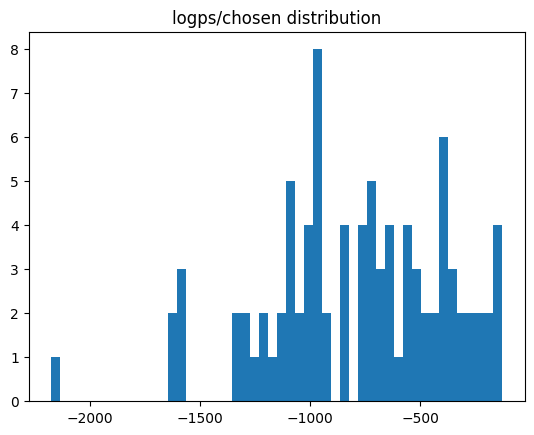

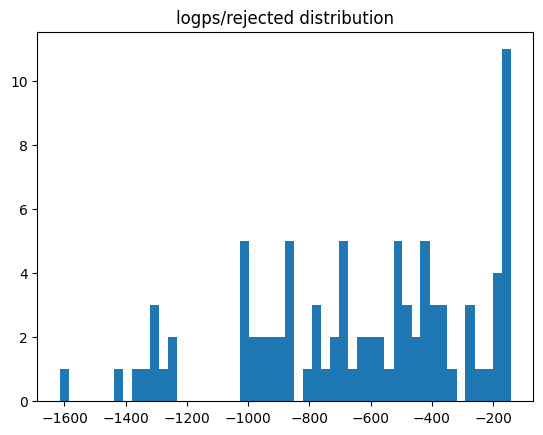

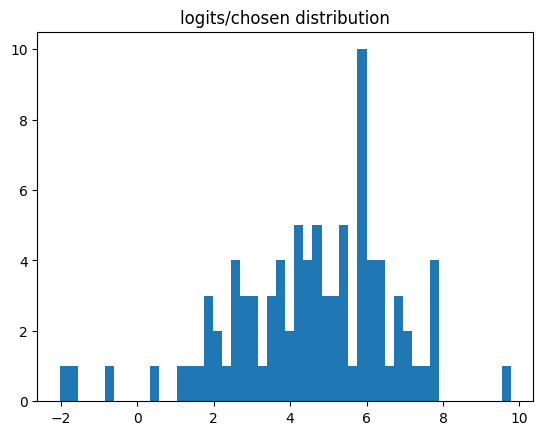

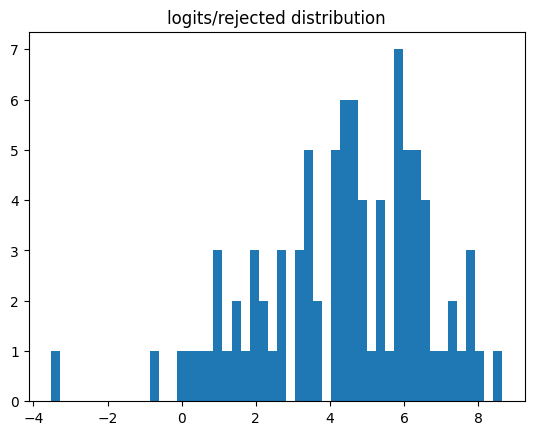

In [36]:
# plot distributiuon of losses
import matplotlib.pyplot as plt
import numpy as np

for metric in outputs[0]['metrics']:
    values = [x['metrics'][metric] for x in outputs]
    plt.hist(values, bins=50)
    plt.title(f'{metric} distribution')
    plt.show()


In [10]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
/admin/home-brianf/smolmodels/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss


TrainOutput(global_step=8, training_loss=0.653107762336731, metrics={'train_runtime': 9.0477, 'train_samples_per_second': 9.947, 'train_steps_per_second': 0.884, 'total_flos': 0.0, 'train_loss': 0.653107762336731, 'epoch': 1.0})